This notebook uses a current PR of gcr-catalogs, make sure you clone the PR and add it to `sys.path`
```
git clone -b coadd_reader git@github.com:djperrefort/gcr-catalogs.git
```

This notebook also requires `FoFCatalogMatching`: https://github.com/yymao/FoFCatalogMatching

In [1]:
import sys
sys.path.insert(0, '/global/common/software/lsst/common/miniconda/current/lib/python3.6/site-packages')
sys.path.insert(0, '/global/homes/b/bhairav/gcr-catalogs')
from collections import defaultdict
import numpy as np
from astropy.coordinates import SkyCoord
import FoFCatalogMatching
from GCR import GCRQuery
import GCRCatalogs
from scipy.optimize import curve_fit
import operator

In [2]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [3]:
coaddCat = GCRCatalogs.load_catalog('dc2_coadd_run1.1p_tract4850')
refCat = GCRCatalogs.load_catalog('dc2_reference_run1.1p')

In [4]:
coaddCat.add_quantity_modifier('i_mag_cmodel', 
                              (lambda x: -2.5 * np.log10(x) + 27.0, 'i_modelfit_CModel_flux'), 
                              overwrite=True)
coaddCat.add_quantity_modifier('i_SN_cmodel', 
                              (np.divide, 'i_modelfit_CModel_flux', 'i_modelfit_CModel_fluxSigma'), 
                              overwrite=True)
coaddCat.add_quantity_modifier('HSM_res', 
                              'ext_shapeHSM_HsmShapeRegauss_resolution', 
                              overwrite=True)
coaddCat.add_quantity_modifier('HSM_ell', 
                              (np.hypot, 'ext_shapeHSM_HsmShapeRegauss_e1', 'ext_shapeHSM_HsmShapeRegauss_e2'), 
                              overwrite=True)
coaddCat.add_quantity_modifier('psf_size', 
                              (lambda xx, yy, xy: 0.168*2.355*(xx*yy - xy*xy)**0.25, 'i_base_SdssShape_psf_xx', 'i_base_SdssShape_psf_yy', 'i_base_SdssShape_psf_xy'),
                              overwrite=True)

In [5]:
#for data in coaddCat.get_quantities(['ra', 'dec'], return_iterator=True):
#    plt.scatter(data['ra'], data['dec'], s=1, rasterized=True);

#plt.xlabel('RA');
#plt.ylabel('Dec');

In [6]:
# do matching on a small area
ra_min, ra_max = 55.5, 56.0
dec_min, dec_max = -29.0, -28.5

coord_filter = GCRQuery(
    'ra >= {}'.format(ra_min),
    'ra < {}'.format(ra_max),
    'dec >= {}'.format(dec_min),
    'dec < {}'.format(dec_max),
)

In [7]:
mag_cutIn = GCRQuery(
    (np.isfinite, 'lsst_u'),
    'lsst_u < 45',
#    (np.isfinite, 'i_magLSST'),
#    'i_magLSST < 24.5',
)
mag_cutOut = GCRQuery(
    (np.isfinite, 'mag_i_lsst'),
    'mag_i_lsst < 24.5'
)

In [9]:
#GCRQuery((np.isnan, 'i_modelfit_CModel_flux')), # (from this and below) remove nan entries
#GCRQuery((np.isnan, 'ext_shapeHSM_HsmShapeRegauss_resolution')),
#GCRQuery((np.isnan, 'ext_shapeHSM_HsmShapeRegauss_e1')),
#GCRQuery((np.isnan, 'ext_shapeHSM_HsmShapeRegauss_e2')),
#GCRQuery('detect_isPrimary'), # (from this and below) basic flag cuts 
#GCRQuery('deblend_skipped'),
#GCRQuery('base_PixelFlags_flag_edge'),
#GCRQuery('base_PixelFlags_flag_interpolatedCenter'),
#GCRQuery('base_PixelFlags_flag_saturatedCenter'),
#GCRQuery('base_PixelFlags_flag_crCenter'),
#GCRQuery('base_PixelFlags_flag_bad'),
#GCRQuery('base_PixelFlags_flag_suspectCenter'),
#GCRQuery('base_PixelFlags_flag_clipped'),
#GCRQuery('ext_shapeHSM_HsmShapeRegauss_flag'),
#GCRQuery('i_SN_cmodel >= 10'), # (from this and below) cut on object properties
#GCRQuery('HSM_res >= 0.3'),
#GCRQuery('HSM_ell < 2.0'),
#GCRQuery('ext_shapeHSM_HsmShapeRegauss_sigma <= 0.4'),
#GCRQuery('i_mag_cmodel < 24.5'), # FIXME: Doesnt have exinction correction
#GCRQuery('base_Blendedness_abs_flux < 10**(-0.375)'),
lensing_cuts = [
    GCRQuery(
    'ra >= {}'.format(ra_min),
    'ra < {}'.format(ra_max),
    'dec >= {}'.format(dec_min),
    'dec < {}'.format(dec_max)),
    GCRQuery('mag_r < 25.5')
]

In [20]:
coordinatesCoaddCat = coaddCat.get_quantities(['ra', 'dec',
                                               'i_modelfit_CModel_flux',
                                               'ext_shapeHSM_HsmShapeRegauss_resolution',
                                               'ext_shapeHSM_HsmShapeRegauss_e1',
                                               'ext_shapeHSM_HsmShapeRegauss_e2',
                                               'detect_isPrimary',
                                               'deblend_skipped',
                                               'base_PixelFlags_flag_edge',
                                               'base_PixelFlags_flag_interpolatedCenter',
                                               'base_PixelFlags_flag_saturatedCenter',
                                               'base_PixelFlags_flag_crCenter',
                                               'base_PixelFlags_flag_bad',
                                               'base_PixelFlags_flag_suspectCenter',
                                               'base_PixelFlags_flag_clipped',
                                               'ext_shapeHSM_HsmShapeRegauss_flag',
                                               'i_SN_cmodel',
                                               'HSM_res',
                                               'HSM_ell',
                                               'ext_shapeHSM_HsmShapeRegauss_sigma',
                                               'i_mag_cmodel',
                                               'base_Blendedness_abs_flux',
                                               'mag_r'
                                              ], filters=lensing_cuts)

coordinatesRefCat = refCat.get_quantities(['ra', 'dec'], filters=[coord_filter])

/global/homes/b/bhairav/.conda/envs/myenv/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
/global/homes/b/bhairav/.conda/envs/myenv/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app
/global/homes/b/bhairav/gcr-catalogs/GCRCatalogs/reference_catalog.py:67: UserWarning: genfromtxt: Empty input file: "<_io.BufferedReader name='/global/projecta/projectdirs/lsst/groups/SSim/DC2/reference_catalogs/dc2_reference_catalog_dc2v2.1.2.txt'>"
  data = np.genfromtxt(f, self._data_dtype, delimiter=',', max_rows=self._nlines)


In [21]:
results = FoFCatalogMatching.match(
    catalog_dict=dict(ref=coordinatesRefCat, coadd=coordinatesCoaddCat),
    linking_lengths=1.0,
    catalog_len_getter=lambda x: len(x['ra']))

In [22]:
n_max = 5
hist2d = np.zeros((n_max, n_max))
ref_idx = defaultdict(list)
coadd_idx = defaultdict(list)

for group in results.groups:
    ref_mask = group['catalog_key'] == 'ref'
    coadd_mask = group['catalog_key'] == 'coadd'
    
    n_ref = np.count_nonzero(ref_mask)
    n_coadd = np.count_nonzero(coadd_mask)
    if n_ref < n_max and n_coadd < n_max:
        hist2d[n_ref, n_coadd] += 1
    
    key = (n_ref, n_coadd)
    ref_idx[key].append(group['row_index'][ref_mask].data)
    coadd_idx[key].append(group['row_index'][coadd_mask].data)

for key in ref_idx:
    ref_idx[key] = np.concatenate(ref_idx[key])
    coadd_idx[key] = np.concatenate(coadd_idx[key])

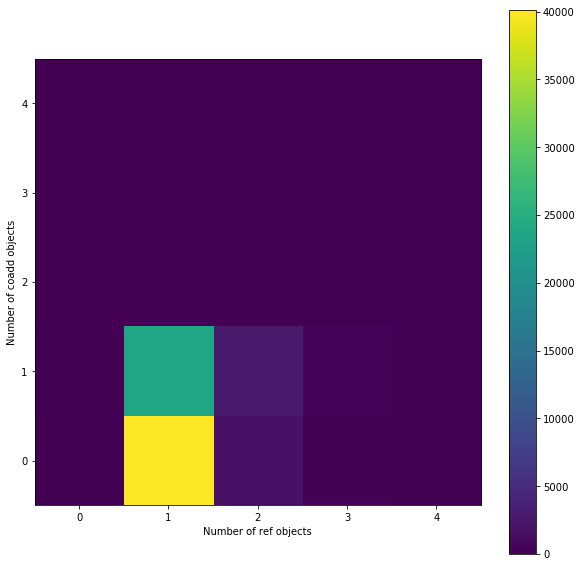

In [23]:
plt.figure(figsize=(10, 10))
plt.imshow(hist2d.T, extent=(-0.5, n_max-0.5, -0.5, n_max-0.5), origin='lower')
plt.xlabel('Number of ref objects')
plt.ylabel('Number of coadd objects')
plt.colorbar()
#ax.xaxis.label.set_color('white')
#ax.tick_params(axis='x', colors='white')
#ax.yaxis.label.set_color('white')
#ax.tick_params(axis='y', colors='white')
#t = cbar.ax.get_yticklabels();
#labels = [item.get_text() for item in t]
#cbar.ax.set_yticklabels(labels, color = 'white')

In [30]:
delta_ra = coordinatesCoaddCat['ra'][coadd_idx[(1,1)]] - coordinatesRefCat['ra'][ref_idx[(1,1)]]
delta_dec = coordinatesCoaddCat['dec'][coadd_idx[(1,1)]] - coordinatesRefCat['dec'][ref_idx[(1,1)]]
ref_sc = SkyCoord(coordinatesRefCat['ra'][ref_idx[(1,1)]], coordinatesRefCat['dec'][ref_idx[(1,1)]], unit="deg")
coadd_sc = SkyCoord(coordinatesCoaddCat['ra'][coadd_idx[(1,1)]], coordinatesCoaddCat['dec'][coadd_idx[(1,1)]], unit="deg")
delta_arcsec = ref_sc.separation(coadd_sc).arcsec

158.0

/global/homes/b/bhairav/.conda/envs/myenv/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log10


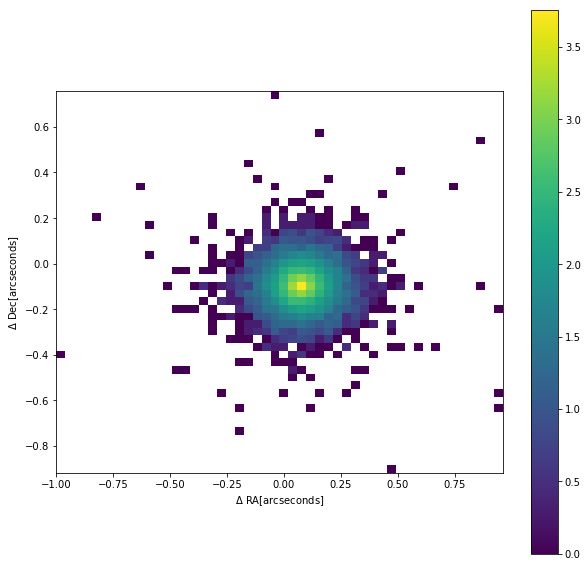

In [25]:
hist, xedges, yedges = np.histogram2d(delta_ra, delta_dec, bins=50)
plt.figure(figsize=(10, 10))
extent = (xedges[0]*3600, xedges[-1]*3600, yedges[0]*3600, yedges[-1]*3600)
plt.imshow(np.log10(hist), extent=extent)

#plt.hist2d(delta_ra, delta_dec, bins=40);
plt.xlabel(r'$\Delta$ RA[arcseconds]')
plt.ylabel(r'$\Delta$ Dec[arcseconds]')
plt.colorbar()

In [26]:
values_list01 = []
values_list11 = []
values_list01.append(int(hist2d[(0,1)]))
values_list11.append(int(hist2d[(1,1)]))

lensing_filters = ['i_modelfit_CModel_flux',
              'ext_shapeHSM_HsmShapeRegauss_resolution',
              'ext_shapeHSM_HsmShapeRegauss_e1', 
              'ext_shapeHSM_HsmShapeRegauss_e2',
              'detect_isPrimary',
              'deblend_skipped',
              'base_PixelFlags_flag_edge',
              'base_PixelFlags_flag_interpolatedCenter',
              'base_PixelFlags_flag_saturatedCenter',
              'base_PixelFlags_flag_crCenter',
              'base_PixelFlags_flag_bad',
              'base_PixelFlags_flag_suspectCenter',
              'base_PixelFlags_flag_clipped',
              'ext_shapeHSM_HsmShapeRegauss_flag',
              'i_SN_cmodel >= 10',
              'HSM_res >= 0.3',
              'HSM_ell < 2.0',
              'ext_shapeHSM_HsmShapeRegauss_sigma <= 0.4',
              'i_mag_cmodel < 24.5',
              'base_Blendedness_abs_flux < 0.42169650342'
             ]

def listParser(listOfFilters):
    rel_ops = set(['<', '<=', '>', '>='])
    operatorsTable = {'<' : operator.lt,
                      '>' : operator.gt,
                      '<=' : operator.le,
                      '>=' : operator.ge}
    for x in listOfFilters:
        if not any(r in x for r in rel_ops):
            a = coordinatesCoaddCat[x][coadd_idx[(0,1)]]
            b = coordinatesCoaddCat[x][coadd_idx[(1,1)]]
            a = a[~np.isnan(a)]
            b = b[~np.isnan(b)]
            values_list01.append(len(a))
            values_list11.append(len(b))
        elif any(r in x for r in rel_ops):
            for index in range(len(x)):
                if x[index] in rel_ops:
                    op = x[index]
                    if (x[index] + x[index+1]) in rel_ops:
                        op += x[index+1]
            for index in range(len(x)):
                if x[index].isdigit():
                    num = x[index:]
                    break
            filterName = ''
            for index in range(len(x)):
                if x[index].isalpha() or x[index]=='_':
                    filterName += x[index]
            print(filterName + ' ' + op + ' ' + num)
            c = operatorsTable[op](coordinatesCoaddCat[filterName][coadd_idx[(0,1)]], float(num))
            d = operatorsTable[op](coordinatesCoaddCat[filterName][coadd_idx[(1,1)]], float(num))
            c = c[~np.isnan(c)]
            d = d[~np.isnan(d)]
            values_list01.append(np.sum(c))
            values_list11.append(np.sum(d))

listParser(lensing_filters)

print(values_list01)
print(values_list11)

i_SN_cmodel >= 10
HSM_res >= 0.3
HSM_ell < 2.0
ext_shapeHSM_HsmShapeRegauss_sigma <= 0.4
i_mag_cmodel < 24.5
base_Blendedness_abs_flux < 0.42169650342
[158, 128, 131, 131, 131, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 66, 119, 123, 110, 98, 38]
[23503, 23429, 19560, 19560, 19560, 23503, 23503, 23503, 23503, 23503, 23503, 23503, 23503, 23503, 23503, 16506, 11918, 17456, 13034, 19841, 22025]


/global/homes/b/bhairav/.conda/envs/myenv/lib/python3.6/site-packages/ipykernel/__main__.py:57: RuntimeWarning: invalid value encountered in greater_equal
/global/homes/b/bhairav/.conda/envs/myenv/lib/python3.6/site-packages/ipykernel/__main__.py:58: RuntimeWarning: invalid value encountered in greater_equal
/global/homes/b/bhairav/.conda/envs/myenv/lib/python3.6/site-packages/ipykernel/__main__.py:57: RuntimeWarning: invalid value encountered in less
/global/homes/b/bhairav/.conda/envs/myenv/lib/python3.6/site-packages/ipykernel/__main__.py:58: RuntimeWarning: invalid value encountered in less
/global/homes/b/bhairav/.conda/envs/myenv/lib/python3.6/site-packages/ipykernel/__main__.py:57: RuntimeWarning: invalid value encountered in less_equal
/global/homes/b/bhairav/.conda/envs/myenv/lib/python3.6/site-packages/ipykernel/__main__.py:58: RuntimeWarning: invalid value encountered in less_equal


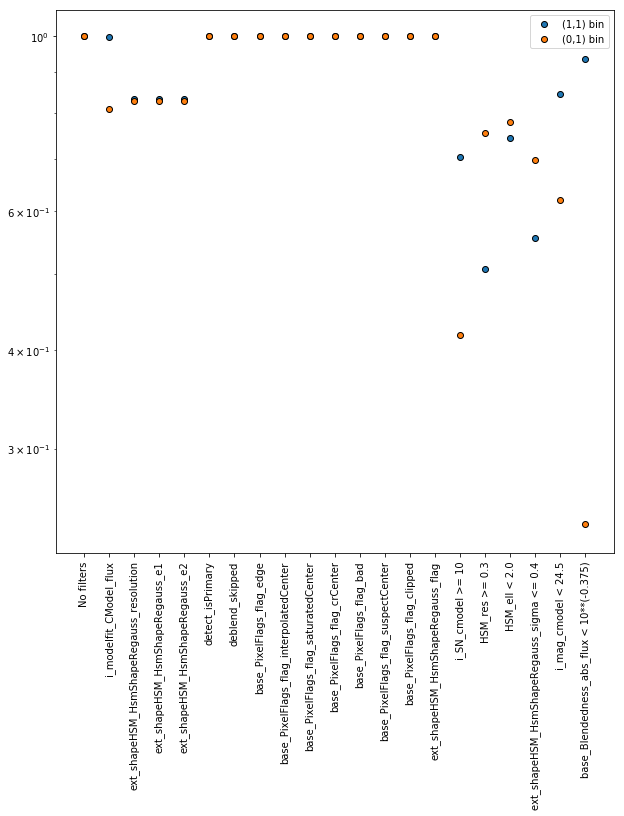

In [29]:
#filter1 = np.count(np.isnan(coordinatesCoaddCat['i_modelfit_CModel_flux'][coadd_idx[(1,1)]]))
filters_list = ['No filters',
              'i_modelfit_CModel_flux',
              'ext_shapeHSM_HsmShapeRegauss_resolution',
              'ext_shapeHSM_HsmShapeRegauss_e1', 
              'ext_shapeHSM_HsmShapeRegauss_e2',
              'detect_isPrimary',
              'deblend_skipped',
              'base_PixelFlags_flag_edge',
              'base_PixelFlags_flag_interpolatedCenter',
              'base_PixelFlags_flag_saturatedCenter',
              'base_PixelFlags_flag_crCenter',
              'base_PixelFlags_flag_bad',
              'base_PixelFlags_flag_suspectCenter',
              'base_PixelFlags_flag_clipped',
              'ext_shapeHSM_HsmShapeRegauss_flag',
              'i_SN_cmodel >= 10',
              'HSM_res >= 0.3',
              'HSM_ell < 2.0',
              'ext_shapeHSM_HsmShapeRegauss_sigma <= 0.4',
              'i_mag_cmodel < 24.5',
              'base_Blendedness_abs_flux < 10**(-0.375)'
             ]
xaxis = list(range(len(filters_list)))
normedList11 = []
normedList01 = []

for i in values_list11:
    normedList11.append(i/max(values_list11))
for i in values_list01:
    normedList01.append(i/max(values_list01))
    
plt.figure(figsize=(10, 10))
plt.scatter(xaxis, normedList11, label='(1,1) bin', edgecolors='black')
plt.scatter(xaxis, normedList01, label='(0,1) bin', edgecolors='black')
plt.xticks(np.arange(len(values_list11)), filters_list, size='medium', rotation=90)
ax = plt.gca()
ax.legend()
ax.set_yscale('log')

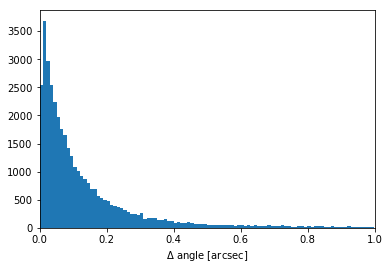

In [18]:
#Plotting Delta angle for the outputs
plt.hist(delta_arcsec, bins=100);
plt.xlim(0, 1.0);
plt.xlabel(r'$\Delta$ angle [arcsec]');

In [19]:
decIn = coordinatesRefCat['dec'][ref_idx[(1,1)]]
decOut = coordinatesCoaddCat['dec'][coadd_idx[(1,1)]]
decIn *= np.pi/180
decOut *= np.pi/180
delta_ra *= np.pi/180
delta_dec *= np.pi/180
meanDec = 0.5 * (decIn + decOut)
deltaDMean = np.sqrt(np.square(delta_ra * np.cos(meanDec)) + np.square(delta_dec))
deltaDMean *= 180*3600/np.pi

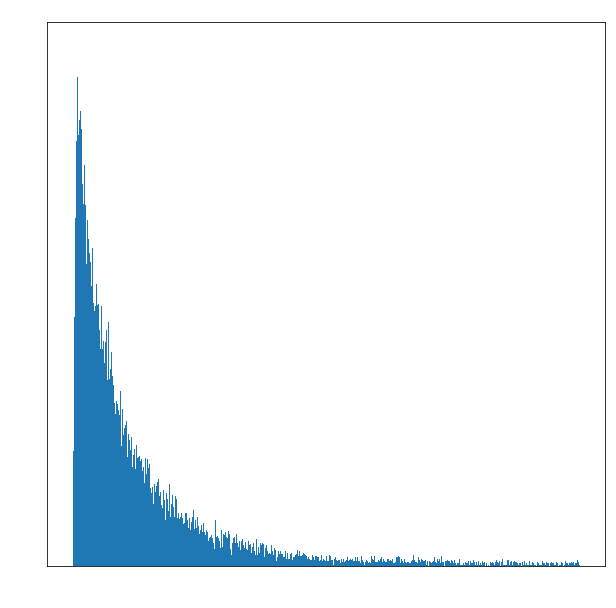

In [121]:
plt.figure(figsize=(10, 10))
plt.title('Mean angular distance', color='white')
plt.xlabel('$\Delta$ Angle [arcsec]', color='white')
plt.ylabel('Frequency', color='white')
ax = plt.gca()
values, edges, _ = plt.hist(deltaDMean, bins=1000)
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

162037.68475
14.9048574774


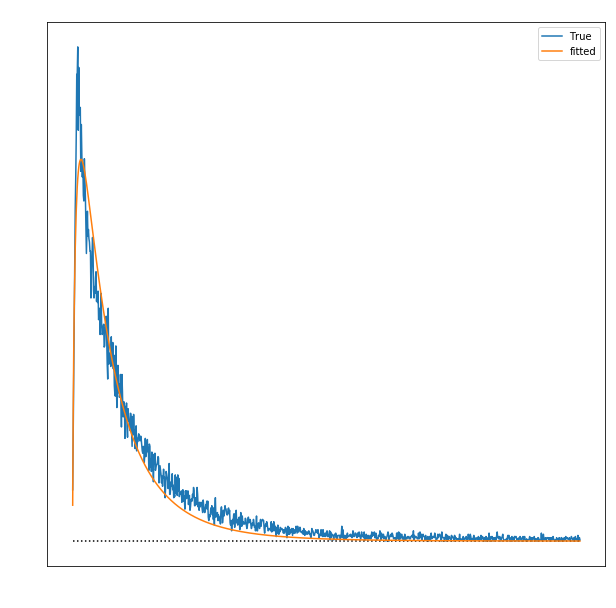

In [122]:
plt.figure(figsize = (10, 10))
plt.plot(edges[:-1], values, label='True')
x_data = edges[:-1]
y_data = values
plt.plot(edges[:-1], values*0., 'k:')
def fitfunction1(x, a, b):
    y = a * x * np.exp(-b * x ** 0.48)
    return y
(A, B), _ = curve_fit(fitfunction1, x_data, y_data)
print(A)
print(B)
ax = plt.gca()
plt.plot(x_data, fitfunction1(x_data, A, B), label='fitted')
plt.title('Fitted with the form a * x * exp(-b * x ** 0.48)', color='white')
plt.xlabel('$\Delta$ Angle [arcsec]', color='white')
plt.ylabel('Frequency', color='white')
plt.legend(loc='upper right')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

In [123]:
magInputs = refCat.get_quantities(['lsst_u',
                                   'lsst_g', 
                                   'lsst_r',
                                   'lsst_i',
                                   'lsst_z',
                                   'lsst_y'], filters=[coord_filter])

/global/homes/b/bhairav/gcr-catalogs/GCRCatalogs/reference_catalog.py:67: UserWarning: genfromtxt: Empty input file: "<_io.BufferedReader name='/global/projecta/projectdirs/lsst/groups/SSim/DC2/reference_catalogs/dc2_reference_catalog_dc2v2.1.2.txt'>"
  data = np.genfromtxt(f, self._data_dtype, delimiter=',', max_rows=self._nlines)


In [124]:
coaddCat.list_all_quantities()
magOutputs = coaddCat.get_quantities(['mag_u',
                                   'mag_g', 
                                   'mag_r',
                                   'mag_i',
                                   'mag_z',
                                   'mag_y'], filters=[coord_filter])

In [141]:
inputU = magInputs['lsst_u']
inputG = magInputs['lsst_g']
inputR = magInputs['lsst_r']
inputI = magInputs['lsst_i']
inputZ = magInputs['lsst_z']
inputY = magInputs['lsst_y']

outputU = magOutputs['mag_u']
outputG = magOutputs['mag_g']
outputR = magOutputs['mag_r']
outputI = magOutputs['mag_i']
outputZ = magOutputs['mag_z']
outputY = magOutputs['mag_y']

In [142]:
inputU11 = (inputU[ref_idx[(1,1)]])
inputG11 = (inputG[ref_idx[(1,1)]])
inputR11 = (inputR[ref_idx[(1,1)]])
inputI11 = (inputI[ref_idx[(1,1)]])
inputZ11 = (inputZ[ref_idx[(1,1)]])
inputY11 = (inputY[ref_idx[(1,1)]])

outputU11 = (outputU[coadd_idx[(1,1)]])
outputG11 = (outputG[coadd_idx[(1,1)]])
outputR11 = (outputR[coadd_idx[(1,1)]])
outputI11 = (outputI[coadd_idx[(1,1)]])
outputZ11 = (outputZ[coadd_idx[(1,1)]])
outputY11 = (outputY[coadd_idx[(1,1)]])

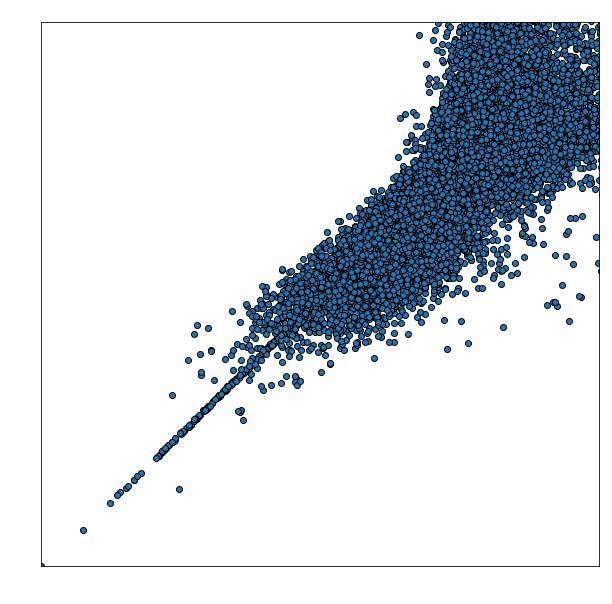

In [145]:
plt.figure(figsize=(10, 10))
plt.scatter(inputU11, outputU11, edgecolors='black')
xmin = min(inputU11)
xmax = 30
ymin = min(outputU11)
ymax = 30
axes = plt.gca()
axes.set_xlim([xmin, xmax])
axes.set_ylim([ymin, ymax])
plt.xlabel("Input Magnitude", color='white')
plt.ylabel("Output Magnitude", color='white')
plt.title("U Band", color='white')
axes.tick_params(axis='x', colors='white')
axes.tick_params(axis='y', colors='white')

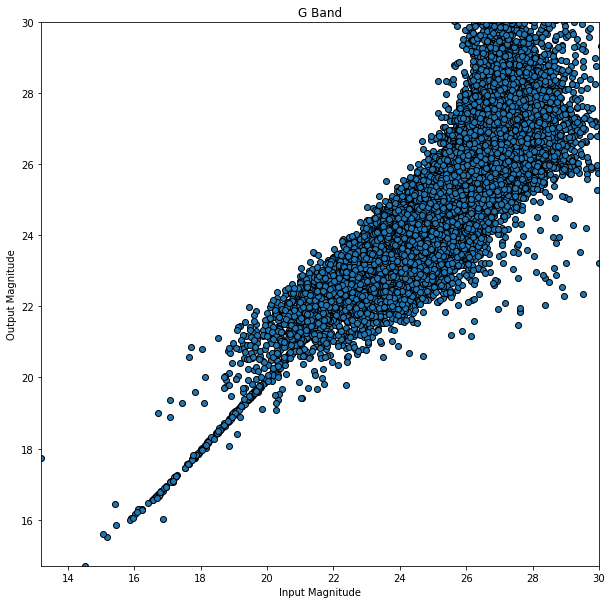

In [128]:
plt.figure(figsize=(10, 10))
plt.scatter(inputG11, outputG11, edgecolors='black')
xmin = min(inputG11)
xmax = 30
ymin = min(outputG11)
ymax = 30
axes = plt.gca()
axes.set_xlim([xmin, xmax])
axes.set_ylim([ymin, ymax])
plt.xlabel("Input Magnitude")
plt.ylabel("Output Magnitude")
plt.title("G Band")
plt.show()

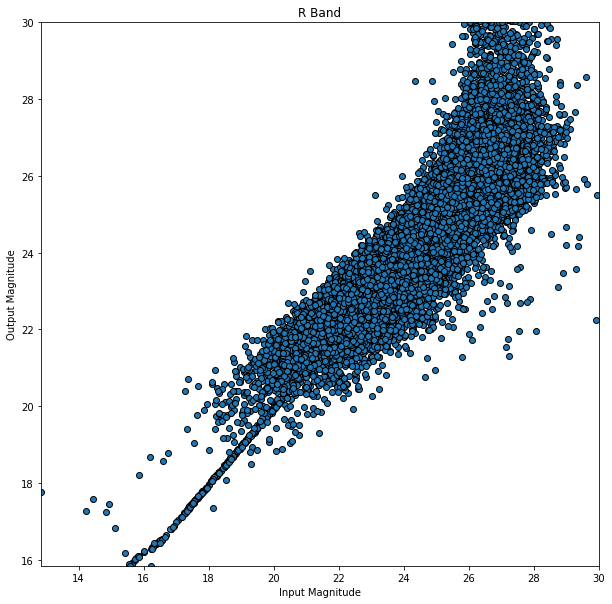

In [129]:
plt.figure(figsize=(10, 10))
plt.scatter(inputR11, outputR11, edgecolors='black')
xmin = min(inputR11)
xmax = 30
ymin = min(outputR11)
ymax = 30
axes = plt.gca()
axes.set_xlim([xmin, xmax])
axes.set_ylim([ymin, ymax])
plt.xlabel("Input Magnitude")
plt.ylabel("Output Magnitude")
plt.title("R Band")
plt.show()

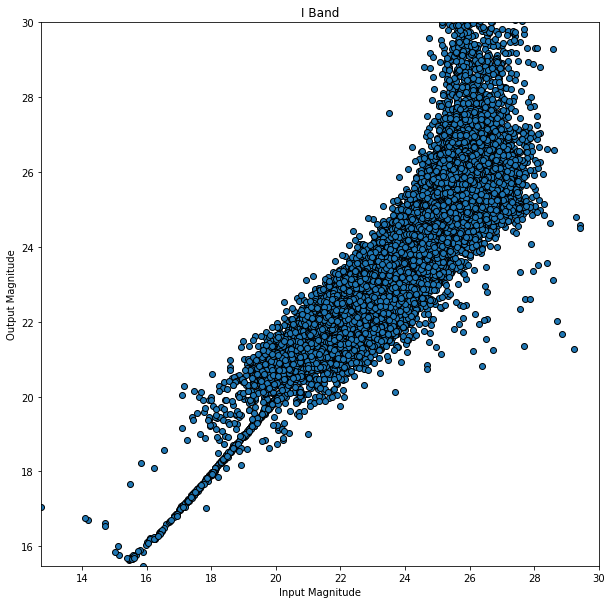

In [130]:
plt.figure(figsize=(10, 10))
plt.scatter(inputI11, outputI11, edgecolors='black')
xmin = min(inputI11)
xmax = 30
ymin = min(outputI11)
ymax = 30
axes = plt.gca()
axes.set_xlim([xmin, xmax])
axes.set_ylim([ymin, ymax])
plt.xlabel("Input Magnitude")
plt.ylabel("Output Magnitude")
plt.title("I Band")
plt.show()

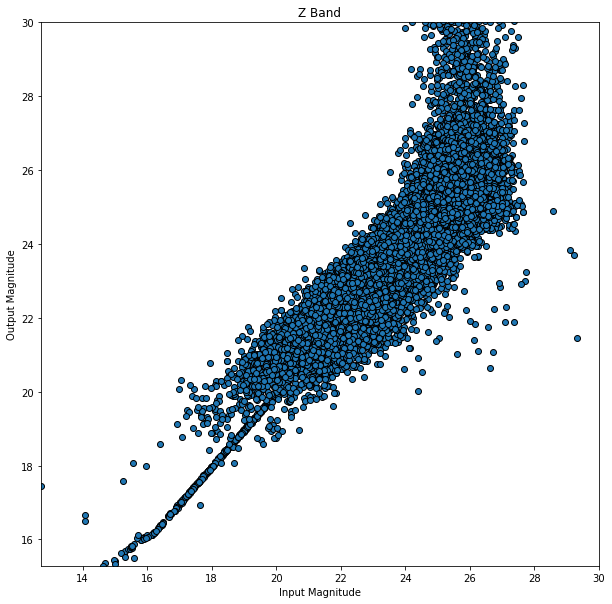

In [131]:
plt.figure(figsize=(10, 10))
plt.scatter(inputZ11, outputZ11, edgecolors='black')
xmin = min(inputZ11)
xmax = 30
ymin = min(outputZ11)
ymax = 30
axes = plt.gca()
axes.set_xlim([xmin, xmax])
axes.set_ylim([ymin, ymax])
plt.xlabel("Input Magnitude")
plt.ylabel("Output Magnitude")
plt.title("Z Band")
plt.show()

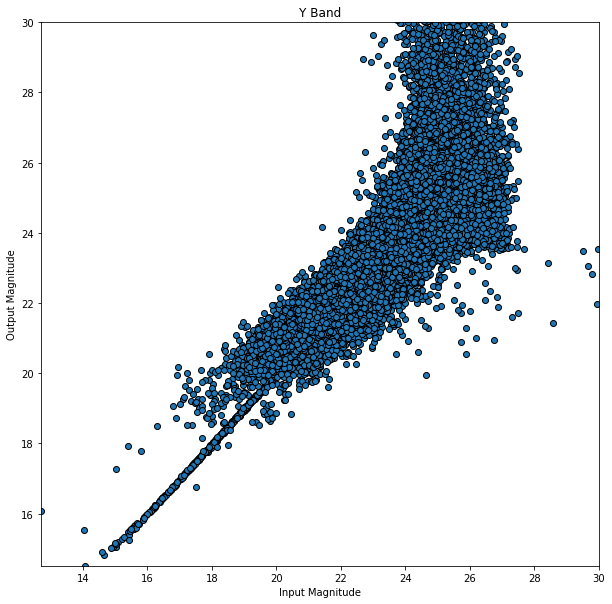

In [132]:
plt.figure(figsize=(10, 10))
plt.scatter(inputY11, outputY11, edgecolors='black')
xmin = min(inputY11)
xmax = 30
ymin = min(outputY11)
ymax = 30
axes = plt.gca()
axes.set_xlim([xmin, xmax])
axes.set_ylim([ymin, ymax])
plt.xlabel("Input Magnitude")
plt.ylabel("Output Magnitude")
plt.title("Y Band")
plt.show()

In [133]:
outputU01 = (outputU[coadd_idx[(0,1)]])
outputU01 = outputU01[~np.isnan(outputU01)]

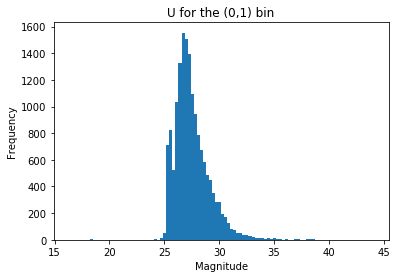

In [134]:
plt.hist(outputU01, bins=100)
plt.xlabel("Magnitude")
plt.ylabel("Frequency")
plt.title("U for the (0,1) bin")

In [135]:
outputU11 = (outputU[coadd_idx[(1,1)]])
print(outputU11)
outputU11 = outputU11[~np.isnan(outputU11)]

[ 29.85934783  27.9020271   21.47349065 ...,  23.97205601  24.66396577
  23.34127465]


[ 29.85934783  27.9020271   21.47349065 ...,  23.97205601  24.66396577
  23.34127465]


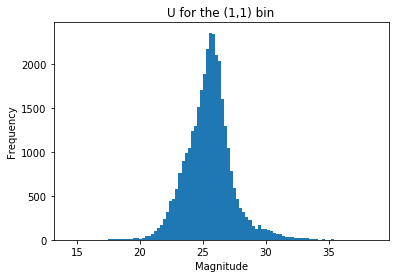

In [136]:
plt.hist(outputU11, bins=100)
plt.xlabel("Magnitude")
plt.ylabel("Frequency")
plt.title("U for the (1,1) bin")
print(outputU11)

In [137]:
outputG01 = (outputG[coadd_idx[(0,1)]])
outputG01 = outputG01[~np.isnan(outputG01)]

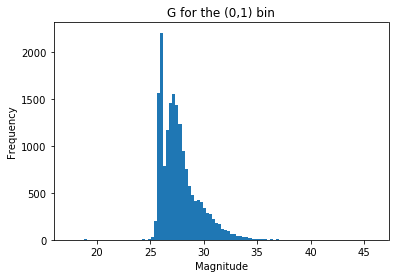

In [138]:
plt.hist(outputG01, bins=100) 
plt.xlabel("Magnitude")
plt.ylabel("Frequency")
plt.title("G for the (0,1) bin")